# Model Building

**Here we built a model to predict the popularity bucket**

- **1Day Trending -> 'JustTrending'**
- **1 to 5 Days Trending-> 'Popular'**
- **5 to 14 Days Trending -> 'UlraPopular'**
- **>14 Days Trending -> 'Phenomenon'**

**Our model has 82% accuracy on train data and 78% accuracy in test data**
**Most of the misidentification are to the adjacent classes**

### Dependencies

In [482]:
#Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
import missingno as msno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from copy import deepcopy
#from datapackage import Package
import matplotlib.pyplot as plt
import numpy as np
#from iso3166 import countries
#import plotly.io as pio
#import math
#from sklearn.feature_selection import f_classif
#from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ConfusionMatrix

### Import and Cleanup

In [498]:
DF = pd.read_pickle("../Data/Popularity_DF.pkl")

In [503]:
##Basic cleanup

#Language fill NaN and cleanup
DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

#Origin Country
DF['Origin_Country'].fillna(value='Not_Disclosed', inplace=True)

#Create Trended_After(Days)
def indays(x,y):
    z=x.date()-y.date()
    return z.days
DF['Trended_After(Days)'] = DF.apply(lambda x: indays(x['First_Trending'],x['Publish_Time']), axis=1)


#Censorship 
DF['censorship'] = DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
#Create output variable
def map_to_cat(x):
    #np.quantile(Country_Category_Popularity_DF['Total_Trend_Days'], [0.95, 0.999])
    #1 -> 'JustTrending'
    #(1 to 5] -> 'Popular' #5 is 95th %
    #(5 to 14] -> 'UlraPopular' #14 is 99.1%
    #>14 -> 'Phenomenon'
    return ('JustTrending' if x==1 else ('Popular' if x<=5 else ('UltraPopular' if x<=14 else "Phenomenon")))
DF['Popularity_Category'] = DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      

#Drop uncecessary columns
DF.drop(['Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

#Check missing values
#_=msno.matrix(DF)

In [504]:
#Consider only countries that produces huge content and code everything else as 'Others'
Top_Origin_Countries = ['Not_Disclosed', 'US', 'RU', 'IN', 'FR', 'DE', 'MX', 'KR', 'JP', 'TR',
       'GB', 'CA', 'ES', 'UA', 'MA']
DF['Origin_Country'] = DF['Origin_Country'].map(lambda x:(x if x in Top_Origin_Countries else 'Others'))
DF['Origin_Country'].unique()

array(['FR', 'Not_Disclosed', 'US', 'RU', 'Others', 'DE', 'JP', 'CA',
       'GB', 'KR', 'IN', 'MX', 'UA', 'TR', 'ES', 'MA'], dtype=object)

In [505]:
#Consider only languages that produces huge content and code everything else as 'Others'
Top_Lang = ['English', 'Spanish', 'French', 'Russian', 'German', 'Icelandic',
       'Unknown', 'Korean', 'Japanese', 'Turkish', 'Arabic', 'Hindi']

DF['Language'] = DF['Language'].map(lambda x:(x if x in Top_Lang else 'Others'))
DF['Language'].unique()

array(['French', 'English', 'Russian', 'Others', 'German', 'Icelandic',
       'Japanese', 'Spanish', 'Unknown', 'Korean', 'Hindi', 'Arabic',
       'Turkish'], dtype=object)

In [506]:
#Convert Duration to minutes
DF['Duration'] = DF['Duration']/60
#Consider only duration <=130 (to remove live sessions)
DF = DF[DF['Duration']<=130]

#Reset Index
DF.reset_index(drop=True, inplace=True)

### Select only the required columns

In [508]:
cat_columns=['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'GoogleAnalyticsUsed', 'IsmoderatingComments']
num_columns=['Duration', 'Views', 'Likes', 'Dislikes', 'Comment_Count', 'Trended_After(Days)', 'PublishedAfter_in_Days']
bin_columns=['Comments_Disabled', 'Ratings_Disabled', 'GoogleAnalyticsUsed', 'IsmoderatingComments']
target=['Popularity_Category']    


In [509]:
Base_Model_DF = DF[num_columns + cat_columns +target].copy()

#Convert target to categorical
Base_Model_DF['Popularity_Category'] = Base_Model_DF['Popularity_Category'].astype(pd.Categorical(['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon'], ordered=True))   

#Convert all other categorical variables to categories (without any order)
Base_Model_DF.loc[:,cat_columns]=Base_Model_DF[cat_columns].astype('category')


### Encoding the Categorical Variables

In [510]:
#OneHotEncoder from SciKit library only takes numerical categorical values, 
#hence any value of string type should be label encoded before one hot encoded.
def encoding(DataFrame, list_of_label_encoding=None, list_of_onehot_encoding=None, drop_first_col=None):
    #This function takes a DF, list of to be label encoding columns, list of one hot encoding columns, 
    #list of  columns with first value to be dropped (in case of binary)
    #Reference:- #https://stats.stackexchange.com/questions/438875/one-hot-encoding-of-a-binary-feature-when-using-xgboost
    #New:- New Data (Need to use the same encoding)
    #Label_Encoder:- Only for new Data
    
    DF = DataFrame.copy()
    Dict_Label_Enc = dict()
    
    if list_of_label_encoding:
        Label_enc = LabelEncoder()
        for col in list_of_label_encoding:
            Label_enc.fit(DF[col])
            DF.loc[:,col] = Label_enc.transform(DF[col])
            Dict_Label_Enc[col] = deepcopy(Label_enc)
       
    if list_of_onehot_encoding:
        no_drop = (list(set(list_of_onehot_encoding).difference(set(drop_first_col))) if drop_first_col else list_of_onehot_encoding)
        DF= pd.get_dummies(DF, columns=no_drop )
        if drop_first_col: 
            DF = pd.get_dummies(DF, columns=drop_first_col, drop_first=True)
        
    return DF, Dict_Label_Enc
        
    
    
    

In [511]:
Encoded_Base_Model_DF, Dict_Label_Enc= encoding(Base_Model_DF, list_of_label_encoding=target, list_of_onehot_encoding=cat_columns, drop_first_col=bin_columns)


In [515]:
Encoded_Cat_Columns=['Category_Autos & Vehicles', 'Category_Comedy', 'Category_Education',
       'Category_Entertainment', 'Category_Film & Animation',
       'Category_Gaming', 'Category_Howto & Style', 'Category_Movies',
       'Category_Music', 'Category_News & Politics',
       'Category_Nonprofits & Activism', 'Category_People & Blogs',
       'Category_Pets & Animals', 'Category_Science & Technology',
       'Category_Shows', 'Category_Sports', 'Category_Trailers',
       'Category_Travel & Events', 'Language_Arabic', 'Language_English',
       'Language_French', 'Language_German', 'Language_Hindi',
       'Language_Icelandic', 'Language_Japanese', 'Language_Korean',
       'Language_Others', 'Language_Russian', 'Language_Spanish',
       'Language_Turkish', 'Language_Unknown', 'viewing_country_CA',
       'viewing_country_DE', 'viewing_country_FR', 'viewing_country_GB',
       'viewing_country_IN', 'viewing_country_JP', 'viewing_country_KR',
       'viewing_country_MX', 'viewing_country_RU', 'viewing_country_US',
       'Origin_Country_CA', 'Origin_Country_DE', 'Origin_Country_ES',
       'Origin_Country_FR', 'Origin_Country_GB', 'Origin_Country_IN',
       'Origin_Country_JP', 'Origin_Country_KR', 'Origin_Country_MA',
       'Origin_Country_MX', 'Origin_Country_Not_Disclosed',
       'Origin_Country_Others', 'Origin_Country_RU', 'Origin_Country_TR',
       'Origin_Country_UA', 'Origin_Country_US', 'Comments_Disabled_True',
       'Ratings_Disabled_True', 'GoogleAnalyticsUsed_True',
       'IsmoderatingComments_True']

### Train Test Split

In [516]:
X_train, X_test, y_train, y_test = train_test_split(Encoded_Base_Model_DF[num_columns+Encoded_Cat_Columns], Encoded_Base_Model_DF[target] , test_size=0.3, random_state=100)  


### Simple XGBoost Model

In [517]:
# Train the XGBoost Model
model = XGBClassifier()
y_train = np.array(y_train).ravel()#XGBoost expects a col vector
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [518]:
# make predictions for train data
y_train_pred = model.predict(X_train)

In [519]:
# evaluate predictions on train data
accuracy = accuracy_score(y_train, y_train_pred)

In [521]:
accuracy#Train accuracy

0.8261409086247564

In [522]:
# make predictions for test data
y_test_pred = model.predict(X_test)

In [523]:
# evaluate predictions on test data
accuracy = accuracy_score(y_test, y_test_pred)

In [524]:
accuracy#Test accuracy

0.7809576224545954

### Confusion Matrix

/Users/bincynarath/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1609bd6a0>,
                classes=array(['JustTrending', 'Phenomenon', 'Popular', 'UltraPopular'],
      dtype=object),
                cmap=<matplotlib.colors.ListedColormap object at 0x13ebf0df0>,
                model=None)

0.7809576224545954

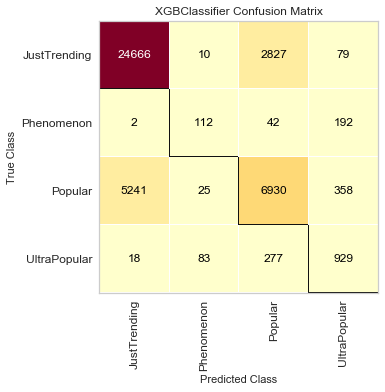

In [525]:
plt.rcParams['figure.figsize'] = [5, 5]
CM = ConfusionMatrix(
    model, classes=Dict_Label_Enc['Popularity_Category'].classes_,
    label_encoder=Dict_Label_Enc['Popularity_Category']
)
CM.fit(X_train, y_train)
CM.score(X_test, y_test)
CM.show()

In [526]:
Dict_Label_Enc['Popularity_Category'].transform(Dict_Label_Enc['Popularity_Category'].classes_)

array([0, 1, 2, 3])

In [527]:
Dict_Label_Enc['Popularity_Category'].classes_

array(['JustTrending', 'Phenomenon', 'Popular', 'UltraPopular'],
      dtype=object)

## Feature Importance

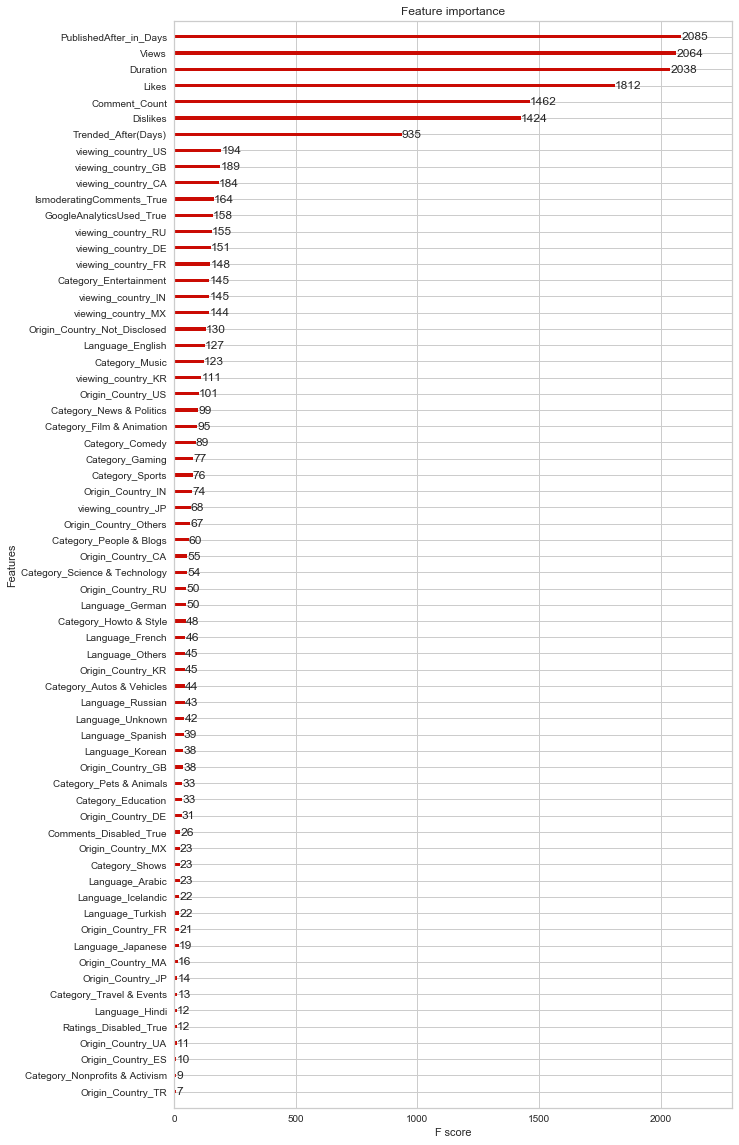

In [528]:
plt.rcParams['figure.figsize'] = [10, 20]
plot_importance(model, color='r')
plt.show()

### Checking a specific video

#### One of the most popular Kylie Jenner Video

In [530]:
KJ = DF[DF['video_id']=='BhIEIO0vaBE']

#This Madeup Data Frame is used to append with all new data before encoding so that dummies get the right names (It is a smart trick!!) 
#Later, this is removed
NO_DUP_DF = DF[cat_columns].drop_duplicates(keep='first').reset_index(drop=True)
NO_DUP_DF[num_columns]=DF.loc[NO_DUP_DF.index,num_columns]
#NO_DUP_DF[num_columns+cat_columns]

KJ_Test=KJ[num_columns+cat_columns]
To_encode = pd.concat([NO_DUP_DF, KJ_Test])
To_encode.reset_index(drop=True, inplace=True)


encoded,_ = encoding(To_encode, list_of_label_encoding=None, list_of_onehot_encoding=cat_columns, drop_first_col=bin_columns)   
KJ_encoded = encoded.iloc[-len(KJ):,:]

KJ_pred=model.predict(KJ_encoded)
KJ_pred
Dict_Label_Enc['Popularity_Category'].inverse_transform(KJ_pred)

KJ.loc[:,'Predicted_Popularity'] = Dict_Label_Enc['Popularity_Category'].inverse_transform(KJ_pred)

KJ[num_columns+cat_columns+target+['Predicted_Popularity']]


array([3, 2, 2, 1, 0, 2, 2, 3])

array(['UltraPopular', 'Popular', 'Popular', 'Phenomenon', 'JustTrending',
       'Popular', 'Popular', 'UltraPopular'], dtype=object)

/Users/bincynarath/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bincynarath/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Duration,Views,Likes,Dislikes,Comment_Count,Trended_After(Days),PublishedAfter_in_Days,viewing_country,Category,Origin_Country,Language,Comments_Disabled,Ratings_Disabled,GoogleAnalyticsUsed,IsmoderatingComments,Popularity_Category,Predicted_Popularity
28366,11.55,20921796,0,0,0,1,954,CA,People & Blogs,Not_Disclosed,English,True,True,False,False,UltraPopular,UltraPopular
28367,11.55,20921796,0,0,0,1,954,DE,People & Blogs,Not_Disclosed,English,True,True,False,False,Popular,Popular
28368,11.55,20921796,0,0,0,1,954,FR,People & Blogs,Not_Disclosed,English,True,True,False,False,Popular,Popular
28369,11.55,20921796,0,0,0,1,954,GB,People & Blogs,Not_Disclosed,English,True,True,False,False,Phenomenon,Phenomenon
28370,11.55,35832484,0,0,0,2,954,KR,People & Blogs,Not_Disclosed,English,True,True,False,False,JustTrending,JustTrending
28371,11.55,20921796,0,0,0,1,954,MX,People & Blogs,Not_Disclosed,English,True,True,False,False,Popular,Popular
28372,11.55,20921796,0,0,0,1,954,RU,People & Blogs,Not_Disclosed,English,True,True,False,False,Popular,Popular
28373,11.55,20921796,0,0,0,1,954,US,People & Blogs,Not_Disclosed,English,True,True,False,False,UltraPopular,UltraPopular


### Random sample of 10 videos

In [531]:
Random = DF.sample(n = 10, random_state=100) 

Random_Test=Random[num_columns+cat_columns]
To_encode = pd.concat([NO_DUP_DF, Random_Test])
To_encode.reset_index(drop=True, inplace=True)


encoded,_ = encoding(To_encode, list_of_label_encoding=None, list_of_onehot_encoding=cat_columns, drop_first_col=bin_columns)   
Random_encoded = encoded.iloc[-len(Random):,:]

Random_pred=model.predict(Random_encoded)
Random_pred
Dict_Label_Enc['Popularity_Category'].inverse_transform(Random_pred)

Random.loc[:,'Predicted_Popularity'] = Dict_Label_Enc['Popularity_Category'].inverse_transform(Random_pred)

Random[num_columns+cat_columns+target+['Predicted_Popularity']]


array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0])

array(['JustTrending', 'JustTrending', 'JustTrending', 'Popular',
       'JustTrending', 'JustTrending', 'JustTrending', 'JustTrending',
       'JustTrending', 'JustTrending'], dtype=object)

,Duration,Views,Likes,Dislikes,Comment_Count,Trended_After(Days),PublishedAfter_in_Days,viewing_country,Category,Origin_Country,Language,Comments_Disabled,Ratings_Disabled,GoogleAnalyticsUsed,IsmoderatingComments,Popularity_Category,Predicted_Popularity
132397,3.633333,9390,880,13,88,0,2630,RU,News & Politics,RU,Icelandic,False,False,False,True,JustTrending,JustTrending
54369,33.316667,20673,817,17,77,1,212,DE,Film & Animation,DE,English,False,False,False,True,JustTrending,JustTrending
89208,11.416667,33008,2029,127,265,1,855,FR,People & Blogs,CA,English,False,False,False,False,JustTrending,JustTrending
38657,22.483333,458103,37045,4601,5616,1,1618,RU,Autos & Vehicles,RU,Russian,False,False,False,False,Popular,Popular
17645,12.883333,44402,597,20,0,1,3014,CA,News & Politics,US,English,True,False,True,False,JustTrending,JustTrending
27308,2.966667,29152,1023,7,23,1,1507,FR,Entertainment,FR,French,False,False,False,False,JustTrending,JustTrending
31248,2.016667,45470,0,0,0,0,3321,JP,Entertainment,JP,Others,True,True,False,False,Popular,JustTrending
107272,46.666667,78290,296,41,49,1,4201,DE,Entertainment,IN,Hindi,False,False,True,False,JustTrending,JustTrending
82496,9.033333,63252,5004,60,1088,1,1812,DE,Entertainment,DE,German,False,False,True,False,Popular,JustTrending
4525,2.100000,278147,10515,245,814,1,1602,CA,Comedy,Others,English,False,False,False,True,JustTrending,JustTrending
